Consider the initial conditions corresponding to two solitons with different amplitudes and initial positions, one tall and one short.
\begin{align}
    &A = 2, &&x_0 = 0.25, \\
    &A = 1, &&x_0 = 0.75.
\end{align}
A key property of KdV solitons is that their speed is directly proportional to their amplitude $c = A/3$. Therefore, the taller soliton $A=2$ will travel faster than the shorter one $A=1$. Starting behind the shorter soliton, the taller one is expected to catch up, interact or collide, and overtake it.

*   Initial state $t=0$: The two solitons are well-separated and appear as distinct localised waves. The taller soliton is on the left.
*   Approach $t > 0$: The taller, faster soliton begins to catch up to the shorter, slower one.
*   Interaction and collision $t \approx 0.6$: The solitons merge into a single, complex wave form. During this interaction, the amplitude of the combined peak is momentarily less than the sum of the individual amplitudes due to nonlinear interaction.
*   Emergence $t > 0.8$: Following the interaction, the two solitons re-emerge, having passed through each other. Their original shapes and amplitudes are well-preserved.
*   Post-interaction $t \approx 1.2$: The taller soliton has now completely overtaken the shorter one and continues to move ahead. One feature of soliton collisions is a phase shift. The taller soliton is shifted forward while the shorter soliton is shifted backward from where they would be projected without the interaction.

For the continuous KdV equation with periodic boundary conditions, mass and energy are conserved quantities. The numerical simulation allows us to check how well the discrete scheme preserves these invariants. The trapezium rule can be used to calculate the mass and energy at each time step.

--- Simulation Parameters ---
Spatial step (h): 0.00391
Temporal step (k): 0.00001
Number of time steps (N): 220197
--------------------------------------------------


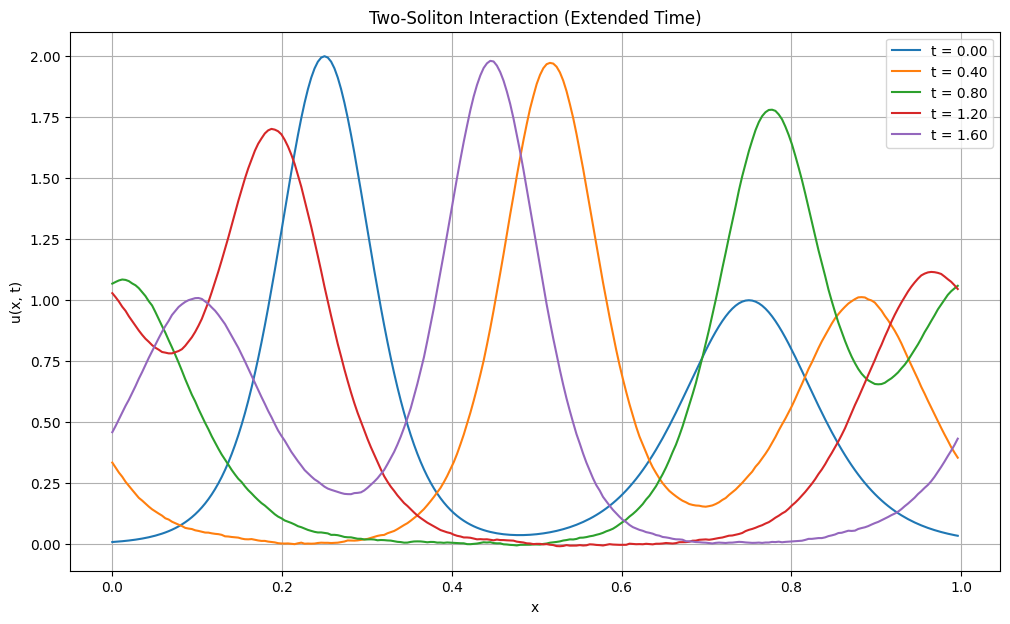

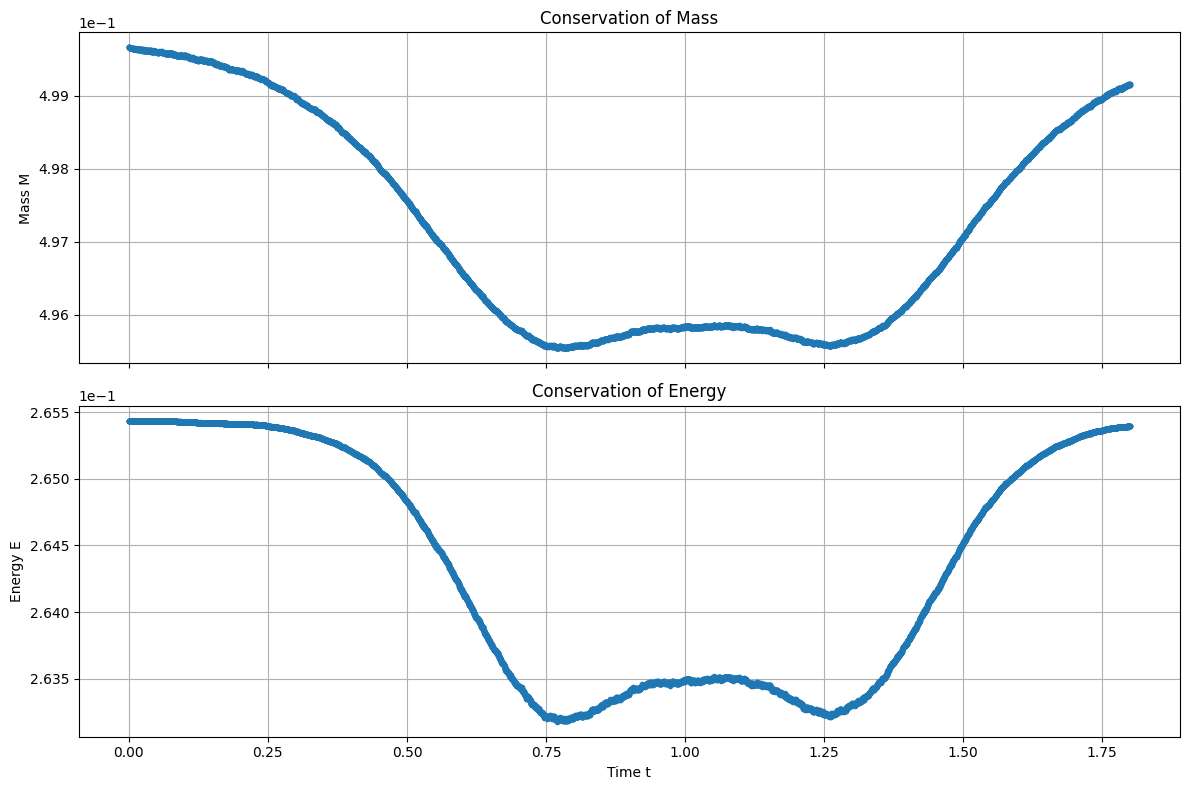

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def setup_parameters(L=1.0, T=1.8, M=256): # Changed T to 1.8 and M to 256
    '''
    Sets up and returns all physical and numerical parameters.
    '''
    delta = 0.03

    # Soliton 1 (taller, faster)
    A1 = 2.0
    x01 = 0.25

    # Soliton 2 (shorter, slower)
    A2 = 1.0
    x02 = 0.75

    h = L / M
    x_grid = np.linspace(0, L, M, endpoint=False)
    # A safe upper bound for the stability condition is the sum of amplitudes
    u_max = A1 + A2

    # Stability condition to determine the time step k
    k_max = h**3 / (4 * delta**2 + h**2 * u_max)
    k = 0.5 * k_max  # Using a safe fraction of the maximum allowed k
    N = int(T / k)

    params = {
        'A1': A1, 'x01': x01, 'A2': A2, 'x02': x02, 'delta': delta,
        'L': L, 'T': T, 'M': M, 'h': h, 'x_grid': x_grid,
        'k': k, 'N': N
    }

    print("--- Simulation Parameters ---")
    print(f"Spatial step (h): {params['h']:.5f}")
    print(f"Temporal step (k): {params['k']:.5f}")
    print(f"Number of time steps (N): {params['N']}")
    print("--------------------------------------------------")

    return params

def get_initial_conditions(params):
    '''
    Calculates the initial state u(x,0) and the state for the first time step u(x,k).
    '''

    def sech_sq(x, A, x0, delta):
        Delta_val = np.sqrt(12 * delta**2 / A)
        return A * (1 / np.cosh((x - x0) / Delta_val))**2

    def soliton_derivs(x, A, x0, delta):
        # Helper function to compute first and third spatial derivatives of a soliton
        Delta_val = np.sqrt(12 * delta**2 / A)
        z = (x - x0) / Delta_val
        sech_z = 1 / np.cosh(z)
        tanh_z = np.tanh(z)

        ux = -2 * A / Delta_val * sech_z**2 * tanh_z
        uxxx = (-2 * A / Delta_val**3) * (-8 * sech_z**2 * tanh_z**3 + 4 * sech_z**4 * tanh_z)

        return ux, uxxx

    u0 = sech_sq(params['x_grid'], params['A1'], params['x01'], params['delta']) + \
         sech_sq(params['x_grid'], params['A2'], params['x02'], params['delta'])

    ux1, uxxx1 = soliton_derivs(params['x_grid'], params['A1'], params['x01'], params['delta'])
    ux2, uxxx2 = soliton_derivs(params['x_grid'], params['A2'], params['x02'], params['delta'])
    ux_total = ux1 + ux2
    uxxx_total = uxxx1 + uxxx2

    ut_0 = -u0 * ux_total - params['delta']**2 * uxxx_total
    u1 = u0 + params['k'] * ut_0

    return u0, u1

def perform_time_step(u_prev, u_curr, params):
    '''
    Performs a single leap-frog time step using vectorised operations.
    '''
    u_curr_p1 = np.roll(u_curr, -1)
    u_curr_m1 = np.roll(u_curr, 1)
    u_curr_p2 = np.roll(u_curr, -2)
    u_curr_m2 = np.roll(u_curr, 2)

    nonlinear = (u_curr + u_curr_p1 + u_curr_m1) * (u_curr_p1 - u_curr_m1)
    dispersive = u_curr_p2 - 2 * u_curr_p1 + 2 * u_curr_m1 - u_curr_m2

    u_next = u_prev - (params['k'] / (3 * params['h'])) * nonlinear - \
             (params['k'] * params['delta']**2 / params['h']**3) * dispersive

    return u_next

def run_simulation(params, conservation_stride=50):
    '''
    Main simulation loop. Tracks mass/energy periodically and stores snapshots.
    '''
    u_prev, u_curr = get_initial_conditions(params)

    time_history, mass_history, energy_history = [], [], []
    snapshots = {}
    # Updated snapshot times for the longer simulation
    snapshot_times = [0, 0.4, 0.8, 1.2, 1.6]

    def calculate_mass(u, h):
        return np.trapezoid(u, dx=h)

    def calculate_energy(u, h):
        return 0.5 * np.trapezoid(u**2, dx=h)

    for n in range(params['N'] + 1):
        current_time = n * params['k']
        # Check if current time is close to a desired snapshot time
        for t_snap in snapshot_times:
            if abs(current_time - t_snap) < params['k'] / 2:
                snapshots[t_snap] = u_curr
                # Avoid duplicates if k is very small
                snapshot_times.remove(t_snap)

        if n % conservation_stride == 0:
            time_history.append(current_time)
            mass_history.append(calculate_mass(u_curr, params['h']))
            energy_history.append(calculate_energy(u_curr, params['h']))

        u_next = perform_time_step(u_prev, u_curr, params)
        u_prev, u_curr = u_curr, u_next

    return snapshots, time_history, mass_history, energy_history

def plot_snapshots(snapshots, params):
    '''
    Generates a plot showing the soliton evolution at different times.
    '''
    plt.figure(figsize=(12, 7))
    # Ensure snapshots are plotted in chronological order
    for t, u in sorted(snapshots.items()):
        plt.plot(params['x_grid'], u, label=f't = {t:.2f}')

    plt.title('Two-Soliton Interaction (Extended Time)')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_conservation(time_hist, mass_hist, energy_hist):
    '''
    Generates plots showing the variation of mass and energy over time.
    '''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax1.plot(time_hist, mass_hist, '.-')
    ax1.set_title('Conservation of Mass')
    ax1.set_ylabel('Mass M')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False)
    ax1.grid(True)

    ax2.plot(time_hist, energy_hist, '.-')
    ax2.set_title('Conservation of Energy')
    ax2.set_ylabel('Energy E')
    ax2.set_xlabel('Time t')
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

params = setup_parameters()
snapshots, time_hist, mass_hist, energy_hist = run_simulation(params, conservation_stride=20)
plot_snapshots(snapshots, params)
plot_conservation(time_hist, mass_hist, energy_hist)

Both mass and energy, which should theoretically be perfectly conserved quantities, are clearly not constant during the simulation. This time interval of non-conservation corresponds exactly to the period when the two solitons are interacting and colliding. Before and after the collision, when the solitons are well-separated, the mass and energy are very nearly constant. The dip-and-recovery profile is roughly symmetric around the point of maximum interaction.

We started the simulation with an initial state $u(x, 0)$ created by simply adding two individual soliton solutions together. For a linear equation, the sum of two solutions is also a solution. However, the KdV equation is nonlinear, so the simple linear superposition of two solitons is not an exact two-soliton solution. It is only a very good approximation when the solitons are far apart.

The difference between our simple initial condition and the true, complex two-soliton solution manifests as a small amount energy. As the simulation begins, the KdV equation evolves this initial state by splitting it into its true components, the two solitons and a dispersive radiation which is greatest during the nonlinear collision.


---

Consider now
\begin{equation}
    u(x, 0) = \sin(2\pi x).
\end{equation}
When $\delta = 0$, the KdV equation simplifies to the inviscid Burgers' equation
\begin{equation}
    u_t + uu_x = 0.
\end{equation}
This is a nonlinear advection equation where the local wave speed is equal to the amplitude $u$. For the abaove initial condition, the positive peak of the wave at $x = 0.254$ has the maximum positive speed and the negative trough at $x = 0.754$ has the maximum negative speed. Points where $u=0$ at $x=0$ and $x=0.5$ are momentarily stationary.

This causes the wave profile to distort. The wave crests move forward faster than the points in front of them, and the troughs move backward faster than the points behind them, leading to a steepening of the wave front. Eventually, the wave profile will become vertical at the point $x=0.5$. Immediately after this, the solution would become multi-valued, which is physically unrealistic and represents the formation of a shock wave.

Instead, we investigate the evolution with a small dispersive term present $\delta = 0.03$. The KdV equation involves the interplay between two effects.
*   Nonlinear steepening $uu_x$: This term causes the wave to steepen towards a shock.
*   Dispersion $\delta^2u_{xxx}$: This term causes different frequency components of the wave to travel at different speeds, effectively spreading the wave out. This term is most significant where the wave is steep.

Initially, the sine wave is smooth, and the nonlinear term dominates causing the wave to steepen. As it steepens, the dispersive term becomes dominant and dispersion prevents the formation of a shock. Instead of breaking, the steep front is resolved into a train of high-frequency oscillations. This phenomenon is known as an undular bore.

For the Burgers' equation, the analytical breaking time is
\begin{equation}
t_b = -\frac{1}{\min(u_x(x,0))}.
\end{equation}
For our initial condition, $u_x(x,0) = 2\pi\cos(2\pi x)$, the minimum value is $-2\pi$ giving a predicted breaking time of $t_b \approx 0.159$. Our numerical solution begins to develop sharp oscillations right around this time.

After the breaking time, the solution evolves into a train of solitons. The initial sine wave decomposes into a series solitons where the number and amplitude of these solitons are determined by the initial conditions and the value of $\delta$. The tallest soliton is the fastest, and the train of solitons spreads out as it travels.


--- Running for δ = 0.03 ---
Spatial step (h): 0.00391
Temporal step (k): 0.00001
Number of time steps (N): 60653
--------------------------------------------------


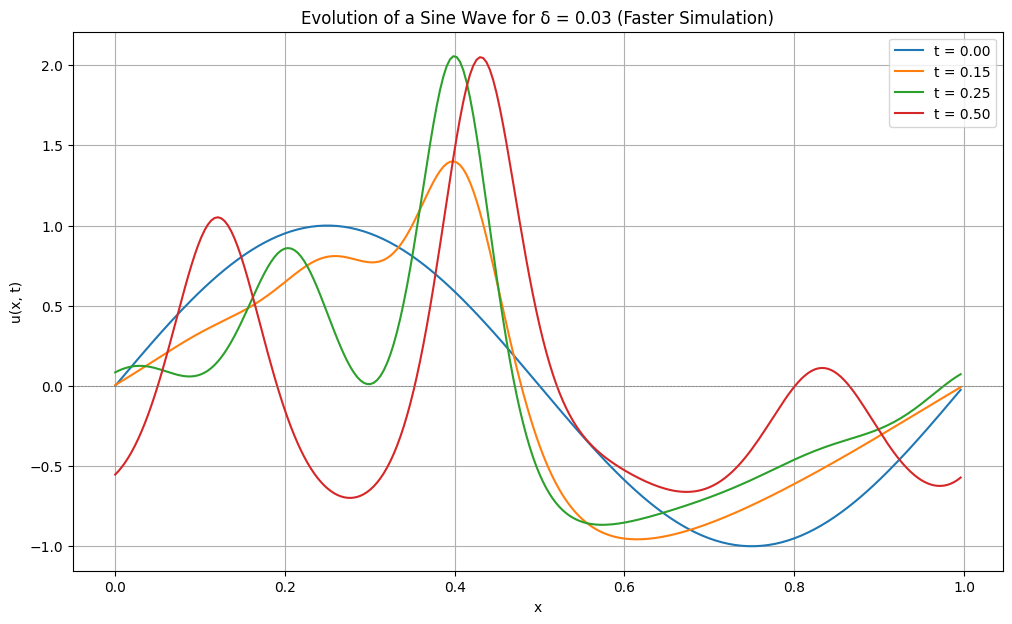


--- Running for δ = 0.01 ---
Spatial step (h): 0.00391
Temporal step (k): 0.00007
Number of time steps (N): 4180
--------------------------------------------------

--- Running for δ = 0.03 ---
Spatial step (h): 0.00391
Temporal step (k): 0.00001
Number of time steps (N): 36392
--------------------------------------------------

--- Running for δ = 0.1 ---
Spatial step (h): 0.00391
Temporal step (k): 0.00000
Number of time steps (N): 402806
--------------------------------------------------


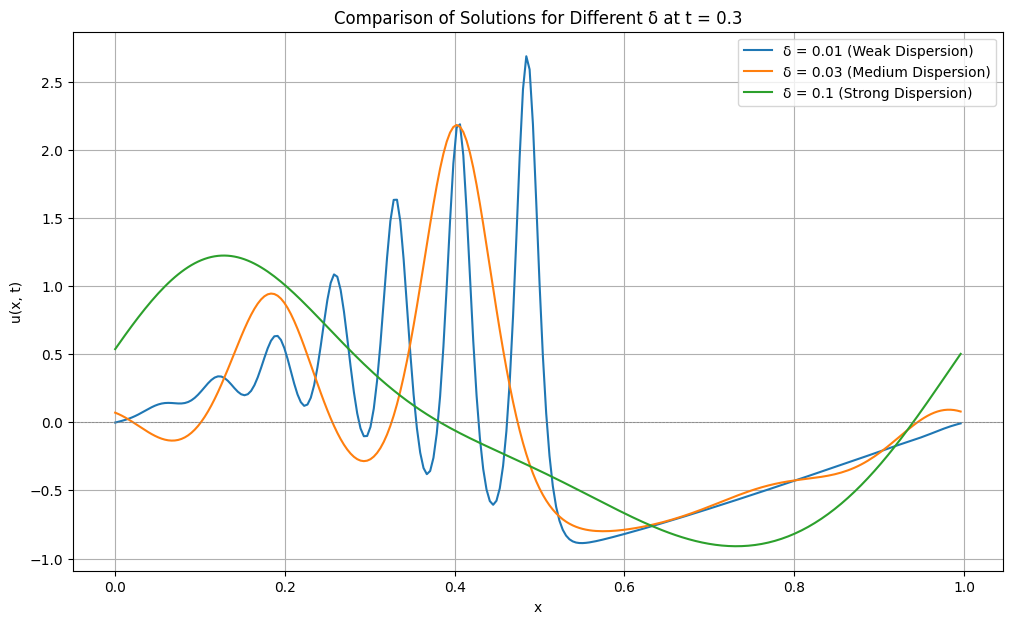

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def setup_parameters(L=1.0, T=0.5, M=256, delta=0.03):
    '''
    Sets up parameters, optimised for faster execution.
    '''
    h = L / M
    x_grid = np.linspace(0, L, M, endpoint=False)
    u_max = 1.0 # Max amplitude of sin(2*pi*x) is 1

    # Stability condition
    k_max = h**3 / (4 * delta**2 + h**2 * u_max)
    k = 0.5 * k_max # Use a safe fraction of the maximum allowed k
    N = int(T / k)

    params = {
        'delta': delta, 'L': L, 'T': T, 'M': M, 'h': h,
        'x_grid': x_grid, 'k': k, 'N': N
    }

    print(f"\n--- Running for δ = {delta} ---")
    print(f"Spatial step (h): {params['h']:.5f}")
    print(f"Temporal step (k): {params['k']:.5f}")
    print(f"Number of time steps (N): {params['N']}")
    print("--------------------------------------------------")

    return params

def get_initial_conditions(params):
    '''
    Calculates initial state for u(x,0) = sin(2*pi*x).
    '''
    x = params['x_grid']

    u0 = np.sin(2 * np.pi * x)
    ux_0 = 2 * np.pi * np.cos(2 * np.pi * x)
    uxxx_0 = -(2 * np.pi)**3 * np.cos(2 * np.pi * x)

    ut_0 = -u0 * ux_0 - params['delta']**2 * uxxx_0
    u1 = u0 + params['k'] * ut_0

    return u0, u1

def perform_time_step(u_prev, u_curr, params):
    '''
    Performs a single leap-frog time step using vectorised operations.
    '''
    u_curr_p1 = np.roll(u_curr, -1)
    u_curr_m1 = np.roll(u_curr, 1)
    u_curr_p2 = np.roll(u_curr, -2)
    u_curr_m2 = np.roll(u_curr, 2)

    nonlinear = (u_curr + u_curr_p1 + u_curr_m1) * (u_curr_p1 - u_curr_m1)
    dispersive = u_curr_p2 - 2 * u_curr_p1 + 2 * u_curr_m1 - u_curr_m2

    u_next = u_prev - (params['k'] / (3 * params['h'])) * nonlinear - \
             (params['k'] * params['delta']**2 / params['h']**3) * dispersive

    return u_next

def run_and_get_snapshots(params, snapshot_times):
    '''
    Runs simulation and returns solutions at specified times using a robust
    method to capture the closest time step to each requested snapshot time.
    '''
    u_prev, u_curr = get_initial_conditions(params)
    snapshots = {}

    remaining_snapshot_times = list(snapshot_times)

    if 0 in remaining_snapshot_times:
        snapshots[0] = u_prev
        remaining_snapshot_times.remove(0)

    for n in range(params['N']):
        u_next = perform_time_step(u_prev, u_curr, params)
        u_prev, u_curr = u_curr, u_next

        current_time = (n + 1) * params['k']

        # Check if the current time is the closest step to any remaining snapshot times
        for t_snap in list(remaining_snapshot_times):
            if abs(current_time - t_snap) < params['k'] / 2:
                snapshots[t_snap] = u_curr
                remaining_snapshot_times.remove(t_snap)

    # Safety Check: If the last snapshot is the final time T and it wasn't captured,
    # assign the last computed state. This handles potential rounding errors at the end.
    if params['T'] in remaining_snapshot_times:
        snapshots[params['T']] = u_curr

    return snapshots

params_03 = setup_parameters(delta=0.03, M=256, T=0.5)
snapshot_times_03 = [0, 0.15, 0.25, 0.5]
snapshots_03 = run_and_get_snapshots(params_03, snapshot_times_03)

plt.figure(figsize=(12, 7))
for t, u in sorted(snapshots_03.items()):
    plt.plot(params_03['x_grid'], u, label=f't = {t:.2f}')
plt.title('Evolution of a Sine Wave for δ = 0.03 (Faster Simulation)')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

T_compare = 0.3
params_small_delta = setup_parameters(delta=0.01, T=T_compare, M=256)
snapshots_small = run_and_get_snapshots(params_small_delta, [T_compare])

params_med_delta = setup_parameters(delta=0.03, T=T_compare, M=256)
snapshots_med = run_and_get_snapshots(params_med_delta, [T_compare])

params_large_delta = setup_parameters(delta=0.1, T=T_compare, M=256)
snapshots_large = run_and_get_snapshots(params_large_delta, [T_compare])

plt.figure(figsize=(12, 7))

# Check if the keys exist before plotting to avoid KeyErrors
if T_compare in snapshots_small:
    plt.plot(params_small_delta['x_grid'], snapshots_small[T_compare], label='δ = 0.01 (Weak Dispersion)')
if T_compare in snapshots_med:
    plt.plot(params_med_delta['x_grid'], snapshots_med[T_compare], label='δ = 0.03 (Medium Dispersion)')
if T_compare in snapshots_large:
    plt.plot(params_large_delta['x_grid'], snapshots_large[T_compare], label='δ = 0.1 (Strong Dispersion)')

plt.title(f'Comparison of Solutions for Different δ at t = {T_compare}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

*   Small $\delta = 0.01$: With very weak dispersion, the nonlinear steepening effect is highly dominant. The solution develops a very sharp front that resolves into a large number of fine, high-frequency oscillations. The behavior is closest to the shock formation of the Burgers' equation.
*   Medium $\delta = 0.03$: This is the case analysed above. A balance between nonlinearity and dispersion leads to a well-defined train of several solitons.
*   Large $\delta = 0.1$: With strong dispersion, the dispersion term becomes significant much earlier and effectively resists the steepening. Only a few, very wide, low-amplitude solitons are formed.

If $\delta$ were made even larger, the solution would behave almost like a linear wave, with dispersion being the overwhelmingly dominant effect.
